# TO DO

0) Add more evaluations
1) Research how to make dimensionality reduction work and still be able to get a prediction
2) Move desired current prediction to the top of the sheet

### Current Parameters:
<a name='Parameters' />

In [1]:
use_post_season = "no" # "yes" means yes, all else is no

# Number of Neurons
neurons_1 = 27
neurons_2 = 10
neurons_3 = 10
neurons_4 = 1

# Activation Types
activation_1 = "relu" # Original: "relu"
activation_2 = "relu"
activation_3 = "relu"
activation_4 = "sigmoid"
activation_outer = "sigmoid"

# Dropout Layer - Rate is the fraction of the inputs to drop between 0 and 1. 0 is none dropped
dropout_rate_1 = .29
dropout_rate_2 = .20
dropout_rate_3 = .20
dropout_rate_4 = .00

# Specify Learning Rate - Default is 0.001
alpha = .00124

# Number of Epochs
num_epochs = 20 # ~20 seems to yield the best results

### Import Dependencies

In [2]:
# !pip install seaborn

In [3]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sqlalchemy import create_engine
from scipy.stats import pearsonr

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os
import joblib

In [4]:
# from numpy.random import seed seed(42) # keras seed fixing import tensorflow as tf 
# tf.random.set_seed(42) # tensorflow seed fixing

# Preprocessing

### Extracting from the Database

In [5]:
rds_connection_string = f"postgres:postgres@localhost:5432/group_2_project_4"
engine = create_engine(f"postgresql://{rds_connection_string}")

nba_df = pd.read_sql_query('select * from reg_season_matches', con=engine)
nba_post = pd.read_sql_query('select * from post_season_matches', con=engine)
reg_season_compiled = pd.read_sql_query('select * from reg_season_stats', con=engine)
post_season_compiled = pd.read_sql_query('select * from post_season_stats', con=engine)

name_abbv = pd.read_sql_query('select * from teams', con=engine)

In [6]:
# post_season_compiled
# reg_season_compiled 
nba_df
# nba_post
# name_abbv

,team,type,opponent,w_l,min,pts,fgm,fga,threepm,threepa,...,fta,oreb,dreb,reb,ast,stl,blk,tov,pf,point_diff
0,MIN,vs,CHI,L,240,120,46,91,11,31,...,22,9,23,32,30,7,9,13,23,-4
1,CHI,@,MIN,W,240,124,44,83,10,21,...,33,16,32,48,22,9,3,23,22,4
2,PHI,vs,DET,W,240,118,46,88,5,25,...,23,10,32,42,25,13,6,11,23,12
3,DET,@,PHI,L,240,106,38,83,11,34,...,29,15,27,42,26,4,4,20,16,-12
4,MEM,vs,BOS,L,240,110,39,102,15,47,...,27,19,26,45,27,11,6,10,16,-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,CHA,@,IND,W,240,123,46,107,13,31,...,27,12,34,46,29,9,5,8,21,1
2456,BKN,vs,MIL,L,240,104,37,84,17,32,...,23,5,39,44,19,3,9,13,17,-23
2457,MIL,@,BKN,W,240,127,48,105,17,45,...,18,13,41,54,25,8,9,8,19,23
2458,LAL,vs,GSW,L,240,114,45,95,15,42,...,19,5,40,45,21,7,4,18,25,-7


### Combine DataFrames

In [7]:
# Create "matches" for the usuable match up data
matches = nba_df[["team", "w_l", "type", "opponent"]].copy()
matches = matches.dropna()

# Merge Agg Data with Abbv to create a dataframe with the aggregate data and the team abbreviation
reg_season_abbv = reg_season_compiled.merge(name_abbv, how = "left", left_on = "team", right_on = "team_name")

# Drop the full team names in favor of the abbv
reg_season_abbv = reg_season_abbv.drop(["team", "team_name"], axis = 1)

# Distinguish Opponent Data from "Defending" Team Data
oppo_reg_season_abbv = reg_season_abbv.add_prefix('OPPO_')

# Merge Team Agg Info with Match Info, twice... Once for defending team, once for opponent
team_games_data = matches.merge(reg_season_abbv, how = "left", left_on = "team", right_on = "abbreviation").merge(oppo_reg_season_abbv, how = "left", left_on = "opponent", right_on = "OPPO_abbreviation")

# Drop target and superfluous columns
team_games_data = team_games_data.drop(["abbreviation", "OPPO_abbreviation"], axis = 1)

# Adding in post-season data:
if use_post_season == "yes":
    
    # Create "post_matches" for the usuable post season match up data
    post_matches = nba_post[["team", "w_l", "type", "opponent"]].copy()
    post_matches = post_matches.dropna()
    
    # Merge Agg Data with Abbv to create a dataframe with the aggregate data and the team abbreviation
    post_season_abbv = post_season_compiled.merge(name_abbv, how = "left", left_on = "team", right_on = "team_name")
    
    # Drop the full team names in favor of the abbv
    post_season_abbv = post_season_abbv.drop(["team", "team_name"], axis = 1)
       
    # Distinguish Opponent Data from "Defending" Team Data
    oppo_post_season_abbv = post_season_abbv.add_prefix('OPPO_')
    
    # Merge Team Agg Info with Match Info, twice... Once for defending team, once for opponent
    post_games_data = post_matches.merge(post_season_abbv, how = "left", left_on = "team", right_on = "abbreviation").merge(oppo_post_season_abbv, how = "left", left_on = "opponent", right_on = "OPPO_abbreviation")
    
    # Drop target and superfluous columns
    post_games_data = post_games_data.drop(["abbreviation", "OPPO_abbreviation"], axis = 1)

    # This is effectively dropping play-in matches until/unless we have play-in stats
    post_games_data = post_games_data.dropna()
    
    # These columns are getting dropped until/unless placeholders can be calculated for items the regular season has that play-off do not. Strength of Schedule, Margin of Victory
    team_games_data = team_games_data.drop(['sos', 'OPPO_srs', 'OPPO_mov', 'OPPO_sos', 'OPPO_attend_g', 'srs', 'attend_g', 'mov'], axis = 1)
    
    # Make the column orders match
    columns = list(team_games_data.columns)
    post_games_data = post_games_data[columns].copy()
    
    # Concat post season games date and regular season games data
    team_games_data = pd.concat([post_games_data, team_games_data], ignore_index=True)
team_games_data

,team,w_l,type,opponent,mp,off_fg,off_fga,off_fg_percent,off_3p,off_3pa,...,OPPO_ts_percent,OPPO_off_efg_percent,OPPO_off_tov_percent,OPPO_off_orb_percent,OPPO_off_ft_fga,OPPO_def_efg_percent,OPPO_def_tov_percent,OPPO_def_drb_percent,OPPO_def_ft_fga,OPPO_attend_g
0,MIN,L,vs,CHI,241.2,41.6,91.0,0.457,14.8,41.3,...,0.579,0.541,11.8,20.4,0.201,0.541,11.9,78.3,0.199,20882
1,CHI,W,@,MIN,240.6,41.7,86.9,0.480,10.6,28.8,...,0.573,0.539,12.4,24.4,0.198,0.535,14.2,74.9,0.227,16028
2,PHI,W,vs,DET,241.5,39.4,84.5,0.466,11.6,31.8,...,0.533,0.494,12.6,23.4,0.194,0.541,13.1,75.6,0.226,16184
3,DET,L,@,PHI,241.2,38.2,88.6,0.431,11.3,34.6,...,0.578,0.534,11.6,20.1,0.232,0.524,12.1,76.8,0.192,20655
4,MEM,L,vs,BOS,241.2,43.5,94.4,0.461,11.5,32.7,...,0.578,0.542,12.4,24.0,0.195,0.502,12.5,77.3,0.183,17754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,CHA,W,@,IND,242.4,42.8,91.4,0.468,13.9,38.2,...,0.564,0.531,12.7,25.5,0.184,0.552,11.9,76.2,0.204,14360
2456,BKN,L,vs,MIL,240.9,42.0,88.4,0.475,11.5,31.7,...,0.580,0.546,11.9,23.0,0.199,0.536,11.6,78.6,0.165,17453
2457,MIL,W,@,BKN,240.9,41.8,89.4,0.468,14.1,38.4,...,0.576,0.540,12.5,23.9,0.198,0.521,11.7,75.1,0.201,17355
2458,LAL,L,vs,GSW,243.7,41.6,88.8,0.469,12.0,34.5,...,0.582,0.552,13.5,22.8,0.181,0.509,13.0,78.7,0.201,18064


In [8]:
# Confirm a lack of differences in columns
if use_post_season == "yes":
    print(list(set(team_games_data.columns) - set(post_games_data.columns))) # Regular Season has these, Post Season doesn't
    print(list(set(post_games_data.columns) - set(team_games_data.columns)))

In [9]:
team_games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2460 entries, 0 to 2459
Columns: 138 entries, team to OPPO_attend_g
dtypes: float64(124), int64(10), object(4)
memory usage: 2.6+ MB


### Visualizing Features

In [10]:
# Create dataframe for only the numerical columns
num_df = team_games_data.select_dtypes(include = np.number)
corr = num_df.corr()

# Correlation map without the correlation values shown

# f, ax = plt.subplots(figsize=(20, 20))
# sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax);

In [11]:
# Correlation map with the correlation values shown
corr.style.background_gradient(cmap='coolwarm')

# Dummies, Scaling, Splitting Data

In [12]:
# Designate the target values as the winning side of w_l
target = team_games_data["w_l"]

y = pd.get_dummies(target)
y = y["W"]
print(f"Shape of target (y): {y.shape}")

# Designate Features and convert categorical data to numeric with `pd.get_dummies`
features = team_games_data.drop(["w_l"], axis = 1)

X = pd.get_dummies(features)
print(f"Shape of features (X): {X.shape}")

Shape of target (y): (2460,)
Shape of features (X): (2460, 196)


In [13]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Feature Scaling

In [14]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Dimensionality Reduction with PCA (Principal Component Analysis)

In [15]:
pca_preserve = 0.999

pca = PCA(n_components = pca_preserve)

# Transform training and testing data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape of training data after PCA: {X_train_pca.shape}")
print(f"Number of columns reduced from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}")
print(f"{pca_preserve * 100}% of explained variance preserved")

Shape of training data after PCA: (1845, 59)
Number of columns reduced from 196 to 59
99.9% of explained variance preserved


# Compile, Train, and Evaluate the Neural Network Models

In [16]:
# Find Best Model from previous runs - This code finds the first model with the highest accuracy in the list, not all models with the same (shared) highest accuracy

def get_best_saved_model():

    if use_post_season == "yes":
        current_folder = "Post_Season"
    else:
        current_folder = "Reg_Season"

    folder_list = os.listdir(f'Models/{current_folder}')       
    model_list = []
    accu_list = []  
    
    # Compile a list of models
    for file in folder_list:
        first_word = file.split("_")[0]
        if first_word == "NBA":
            model_list.append(file)

    # Exract the accuracy of the models
    for model in model_list:
        model_name = model.split(".")[0]
        model_accu = model_name[-4:]
        accu_list.append(model_accu)

    # Find the index of the best accuracy
    best_saved_accuracy = max(accu_list)
    index = accu_list.index(best_saved_accuracy)
    
    # Get the name of the best saved model
    best_saved_model = model_list[index]
        
    return int(best_saved_accuracy), best_saved_model, current_folder

Go to <a href=#Parameters>Current Parameters</a>

In [17]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_features = len(X_train_pca[0])

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = neurons_1, activation = activation_1, input_dim = num_features))

# First dropout layer
nn.add(tf.keras.layers.Dropout(rate = dropout_rate_1, noise_shape=None, seed=None))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = neurons_2, activation = activation_2))

# Second dropout layer
nn.add(tf.keras.layers.Dropout(rate = dropout_rate_2, noise_shape=None, seed=None))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units = neurons_3, activation = activation_3))

# Third dropout layer
nn.add(tf.keras.layers.Dropout(rate = dropout_rate_3, noise_shape=None, seed=None))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units = neurons_4, activation = activation_4))

# Third dropout layer
nn.add(tf.keras.layers.Dropout(rate = dropout_rate_4, noise_shape=None, seed=None))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation = activation_outer))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 27)                1620      
                                                                 
 dropout (Dropout)           (None, 27)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                280       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [18]:
# Specify learning rate and compile the model
opt = keras.optimizers.Adam(learning_rate = alpha)

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer=opt, metrics=["binary_accuracy"])

In [19]:
# Train the model
fit_model = nn.fit(X_train_pca, y_train, epochs=num_epochs)

Epoch 1/20
58/58 [==============================] - 0s 773us/step - loss: 0.7335 - binary_accuracy: 0.4808
Epoch 2/20
58/58 [==============================] - 0s 751us/step - loss: 0.7053 - binary_accuracy: 0.5230
Epoch 3/20
58/58 [==============================] - 0s 770us/step - loss: 0.6868 - binary_accuracy: 0.5604
Epoch 4/20
58/58 [==============================] - 0s 785us/step - loss: 0.6818 - binary_accuracy: 0.5794
Epoch 5/20
58/58 [==============================] - 0s 768us/step - loss: 0.6785 - binary_accuracy: 0.5886
Epoch 6/20
58/58 [==============================] - 0s 778us/step - loss: 0.6805 - binary_accuracy: 0.5924
Epoch 7/20
58/58 [==============================] - 0s 767us/step - loss: 0.6691 - binary_accuracy: 0.6255
Epoch 8/20
58/58 [==============================] - 0s 820us/step - loss: 0.6664 - binary_accuracy: 0.6119
Epoch 9/20
58/58 [==============================] - 0s 820us/step - loss: 0.6661 - binary_accuracy: 0.6201
Epoch 10/20
58/58 [==================

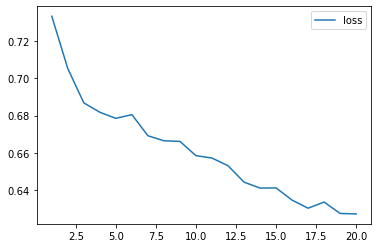

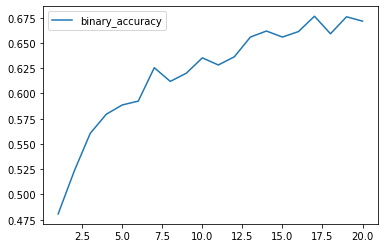

In [20]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
history_df.plot(y="binary_accuracy");

In [21]:
# Evaluate the model using the test data
current_model_loss, current_model_accuracy = nn.evaluate(X_test_pca, y_test, verbose=0)
print(f"Loss: {current_model_loss}, Accuracy: {current_model_accuracy}")

Loss: 0.6467393636703491, Accuracy: 0.6276422739028931


In [22]:
# Define best_saved_accuracy so that only models with better accuracy are saved
best_saved_accuracy, best_saved_model, current_folder = get_best_saved_model()

accu_formatted = "{:.2%}".format(current_model_accuracy)
accu = round(current_model_accuracy * 10_000)

model_source = "basic"

# Save and export results to an HDF5 file
if accu > best_saved_accuracy: # best_saved_accuracy
    nn.save(f"Models/{current_folder}/NBA_model_{model_source}{accu}.h5", include_optimizer=False)
    print(f"Model saved with {accu_formatted} accuracy in {current_folder}")
else:
    saved_accu_formatted = "{:.2%}".format(best_saved_accuracy / 10000)
    print(f"The model was not saved as the {accu_formatted} accuracy is not higher than {saved_accu_formatted}.")

The model was not saved as the 62.76% accuracy is not higher than 65.20%.


Go to <a href=#Parameters>Current Parameters</a>

# GAME PREDICTION

In [39]:
# Boston Celtics BOS @ Golden State Warriors GSW

# Test predictions on PHX vs. HOU

team_A = "GSW" #TEAM
game_type = "@" #TYPE
team_B = "BOS" #OPPONENT

d = {"team": team_A, "type": game_type, "opponent": team_B}

current_match = pd.DataFrame(data = d, index=[0])
current_match

,team,type,opponent
0,GSW,@,BOS


### Create dataframe that matches the columns from "X_train_pca"

In [40]:
# Merge aggregate info into the match data frame
if use_post_season == "yes":
    current_game_data = current_match.merge(post_season_abbv, how = "left", left_on = "team", right_on = "abbreviation").merge(oppo_post_season_abbv, how = "left", left_on = "opponent", right_on = "OPPO_abbreviation")
    current_game_data = pd.get_dummies(current_game_data.drop(["abbreviation", "OPPO_abbreviation"], axis = 1))
else:
    current_game_data = current_match.merge(reg_season_abbv, how = "left", left_on = "team", right_on = "abbreviation").merge(oppo_reg_season_abbv, how = "left", left_on = "opponent", right_on = "OPPO_abbreviation")
    current_game_data = pd.get_dummies(current_game_data.drop(["abbreviation", "OPPO_abbreviation"], axis = 1))

# Add missing columns and assign a value of "0" for each
fill_list = list(set(X.columns) - set(current_game_data.columns))

for i in fill_list:
    current_game_data[i] = 0

# Make the column orders match
columns = list(X_train.columns)
current_game_data = current_game_data[columns].copy()

# Scale and PCA transform
X_new = X_scaler.transform(current_game_data)
X_new = pca.transform(X_new)

# Confirm a lack of differences between columns
print(list(set(current_game_data.columns) - set(X_train.columns)))
print(list(set(X_train.columns) - set(current_game_data.columns)))

[]
[]


## Prediction from the Current Model

In [41]:
# Use dataframe of current match data to generate prediction - https://machinelearningmastery.com/make-predictions-scikit-learn/
y_new = nn.predict([X_new])

# Format values for print statement
win_chance = "{:.2%}".format(y_new[0][0])
model_accuracy_perc = "{:.2%}".format(current_model_accuracy)

# Print prediction
print(f"{team_A} has a {win_chance} chance to win {game_type} {team_B} according to the current model ({model_accuracy_perc} accuracy).")

1/1 [==============================] - 0s 62ms/step
GSW has a 41.68% chance to win @ BOS according to the current model (63.90% accuracy).


## Prediction from Best Saved Model

In [42]:
# Load the model
saved_model = keras.models.load_model(f"Models/{current_folder}/{best_saved_model}")

# Evaluate the model using the test data
saved_model_loss, saved_model_accuracy = saved_model.evaluate(X_test_pca, y_test, verbose=2)
print(f"{best_saved_model} Loss: {saved_model_loss}, Accuracy: {saved_model_accuracy}\n")

# Calculate prediction
y_new = saved_model.predict([X_new])

# Format values for print statement
win_chance = "{:.2%}".format(y_new[0][0])
model_accuracy_perc = "{:.2%}".format(saved_model_accuracy)

# Print prediction
print(f"{team_A} has a {win_chance} chance to win {game_type} {team_B} according to the best saved model ({model_accuracy_perc} accuracy).")

20/20 - 0s - loss: 0.6288 - binary_accuracy: 0.6992 - 87ms/epoch - 4ms/step
NBA_model_auto6992.h5 Loss: 0.6287508606910706, Accuracy: 0.6991869807243347

1/1 [==============================] - 0s 34ms/step
GSW has a 49.89% chance to win @ BOS according to the best saved model (69.92% accuracy).


# Automated Optimization
The auto-optimizer will not create new models unless "untitled_project" is deleted/renamed first

In [43]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid', 'softmax'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=2), activation=activation, input_dim=num_features))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=35,
            step=3),
            activation=activation))
        # Dropout layer
        nn_model.add(tf.keras.layers.Dropout(rate = dropout_rate_1))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Define optimizer
    opt = keras.optimizers.Adam(learning_rate = alpha)
    
    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["binary_accuracy"])
    
    return nn_model

In [44]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_binary_accuracy",
    max_epochs=50,
    hyperband_iterations=2)

In [45]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_pca, y_train, epochs = num_epochs, validation_data=(X_test_pca, y_test))

Trial 180 Complete [00h 00m 04s]
val_binary_accuracy: 0.6796748042106628

Best val_binary_accuracy So Far: 0.6926829218864441
Total elapsed time: 00h 04m 20s
INFO:tensorflow:Oracle triggered exit


In [46]:
X_train_pca.shape, X_test_pca.shape

((1845, 59), (615, 59))

In [47]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters()[0]
best_hyper.values

{'activation': 'sigmoid',
 'first_units': 15,
 'num_layers': 1,
 'units_0': 34,
 'units_1': 4,
 'units_2': 4,
 'units_3': 28,
 'units_4': 4,
 'units_5': 22,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0142'}

In [48]:
def get_best_model(nn, parameters, X_train_scaled, y_train):
    clf = GridSearchCV(model, parameters, cv=4, n_jobs=-1)
    clf.fit(X_train, y_train)
    # print(clf.best_params_)
    return clf.best_estimator_ 

The following cell will start to break if you run it too many times before restarting the kernal

In [49]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
auto_model_loss, auto_model_accuracy = best_model.evaluate(X_test_pca, y_test, verbose=2)
print(f"Loss: {auto_model_loss}, Accuracy: {auto_model_accuracy}")

20/20 - 0s - loss: 0.6575 - binary_accuracy: 0.6927 - 124ms/epoch - 6ms/step
Loss: 0.6575177907943726, Accuracy: 0.6926829218864441


In [51]:
# Define best_saved_accuracy so that only models with better accuracy are saved
best_saved_accuracy, best_saved_model, current_folder = get_best_saved_model()

accu_formatted = "{:.2%}".format(auto_model_accuracy)
accu = round(auto_model_accuracy * 10_000)

model_source = "auto"

# Save and export results to an HDF5 file
if accu > best_saved_accuracy: # or use best_saved_accuracy
    best_model.save(f"Models/{current_folder}/NBA_model_{model_source}{accu}.h5")
    print(f"Model saved with {accu_formatted} accuracy in {current_folder}")
else:
    saved_accu_formatted = "{:.2%}".format(best_saved_accuracy / 10000)
    print(f"The model was not saved as the {accu_formatted} accuracy is not higher than {saved_accu_formatted}.")

The model was not saved as the 69.27% accuracy is not higher than 69.92%.


# SAVE EXPERIMENT - Verify Save and Reload

In [72]:
save_test = best_model
test_model_loss, test_model_accuracy = save_test.evaluate(X_test_pca, y_test, verbose=2)
print(f"Loss: {test_model_loss}, Accuracy: {test_model_accuracy}")
save_test.save("Models/save_test.h5")

load_test = load_model("Models/save_test.h5")
test_model_loss, test_model_accuracy = load_test.evaluate(X_test_pca, y_test, verbose=2)
print(f"Loss: {test_model_loss}, Accuracy: {test_model_accuracy}")

test_accu = round(test_model_accuracy * 10000)

best_model.save(f"Models/{current_folder}/NBA_model_{model_source}{accu}.h5")
load_test_2 = load_model(f"Models/Reg_Season/NBA_model_auto{test_accu}.h5")
test_model_loss, test_model_accuracy = load_test_2.evaluate(X_test_pca, y_test, verbose=2)
print(f"Loss: {test_model_loss}, Accuracy: {test_model_accuracy}")

20/20 - 0s - loss: 0.6288 - binary_accuracy: 0.6992 - 23ms/epoch - 1ms/step
Loss: 0.6287508606910706, Accuracy: 0.6991869807243347
20/20 - 0s - loss: 0.6288 - binary_accuracy: 0.6992 - 85ms/epoch - 4ms/step
Loss: 0.6287508606910706, Accuracy: 0.6991869807243347
20/20 - 0s - loss: 0.6288 - binary_accuracy: 0.6992 - 85ms/epoch - 4ms/step
Loss: 0.6287508606910706, Accuracy: 0.6991869807243347


## Auto-Optimizer Prediction

In [52]:
y_auto_model = best_model.predict([X_new])

win_chance = "{:.2%}".format(y_auto_model[0][0])
model_accuracy_perc = "{:.2%}".format(auto_model_accuracy)

print(f"{team_A} has a {win_chance} chance to win {game_type} {team_B} according to the best auto-optimized model ({model_accuracy_perc} accuracy).")

1/1 [==============================] - 0s 36ms/step
GSW has a 53.84% chance to win @ BOS according to the best auto-optimized model (69.27% accuracy).


# Alternate Experiments

In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [55]:
y_true = y_test
y_pred = saved_model.predict(X_test_pca)

20/20 [==============================] - 0s 735us/step


https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

In [18]:
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10],
              'gamma': [0.0001, 0.001, 0.01]}
grid = GridSearchCV(model, param_grid, verbose=3)

NameError: name 'model' is not defined

In [130]:
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .................C=1, gamma=0.0001;, score=0.559 total time=   0.3s
[CV 2/5] END .................C=1, gamma=0.0001;, score=0.615 total time=   0.2s
[CV 3/5] END .................C=1, gamma=0.0001;, score=0.581 total time=   0.3s
[CV 4/5] END .................C=1, gamma=0.0001;, score=0.627 total time=   0.2s
[CV 5/5] END .................C=1, gamma=0.0001;, score=0.619 total time=   0.2s
[CV 1/5] END ..................C=1, gamma=0.001;, score=0.559 total time=   0.3s
[CV 2/5] END ..................C=1, gamma=0.001;, score=0.615 total time=   0.2s
[CV 3/5] END ..................C=1, gamma=0.001;, score=0.581 total time=   0.3s
[CV 4/5] END ..................C=1, gamma=0.001;, score=0.627 total time=   0.2s
[CV 5/5] END ..................C=1, gamma=0.001;, score=0.619 total time=   0.2s
[CV 1/5] END ...................C=1, gamma=0.01;, score=0.559 total time=   0.2s
[CV 2/5] END ...................C=1, gamma=0.01;,

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [1, 5, 10], 'gamma': [0.0001, 0.001, 0.01]},
             verbose=3)

In [42]:
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

C:\Users\emera\AppData\Local\Temp\ipykernel_7596\2457478790.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)


In [39]:
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# param_grid = dict(activation=activation)


# param_grid = dict(epochs=[10, 20, 30])
# grid = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_train, y_train)

### Support-Vector Machine (SVM)

In [22]:
from sklearn.svm import SVC 
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_pca, y_train)
svm_model.score(X_test_pca, y_test)

0.6130081300813008

In [23]:
svm_model.predict(X_new)

NameError: name 'X_new' is not defined

### RandomForestsClassifier

In [62]:
rfc = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_pca, y_train)

In [63]:
print(f'Training Score: {rfc.score(X_train_pca, y_train)}')
print(f'Testing Score: {rfc.score(X_test_pca, y_test)}')

Training Score: 0.8563685636856369
Testing Score: 0.6048780487804878


In [102]:
flatten=[]
for x in range(X_new[0].size):
    flatten.append(X_new[0][x])
#print(test)
y_rfc = rfc.predict([flatten])
y_rfc

array([0], dtype=uint8)

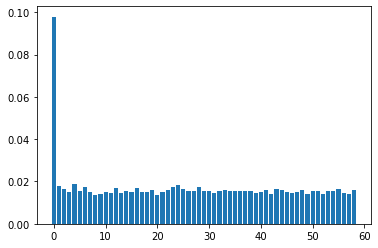

In [64]:
features = rfc.feature_importances_
# print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

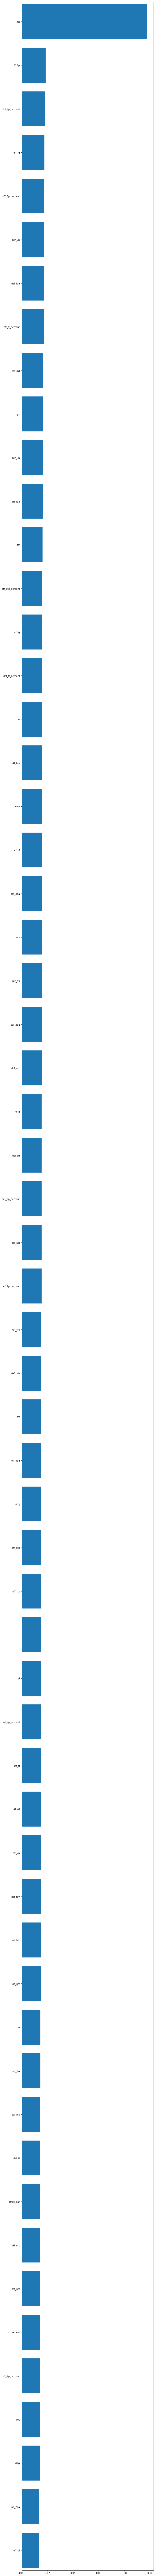

In [65]:
features = sorted(zip(X.columns, rfc.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,200)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [66]:
# Attempt Feature Selection

from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(rfc)
sel.fit(X_train_scaled, y_train)
sel.get_support()

array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True, False, False, False,  True, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False, False,  True, False,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False, False, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True,  True, False,  True, False, False, False,  True, False,
        True, False, False,  True, False, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True, False, False,
        True,  True, False,  True, False,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,

In [67]:
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)

scaler = StandardScaler().fit(X_selected_train)

X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

C:\Users\emera\anaconda3\envs\tf2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [68]:
clf = LogisticRegression()
clf.fit(X_selected_train_scaled, y_train)
print(f'Training Score: {clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_selected_test_scaled, y_test)}')

Training Score: 0.6601626016260163
Testing Score: 0.6634146341463415


C:\Users\emera\anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
test=[]
for x in range(X_new[0].size):
    test.append(X_new[0][x])
#print(test)
y_rfc = rfc.predict([test])
y_rfc

array([1], dtype=uint8)

In [70]:
y_rfc = rfc.predict([X_new])
y_rfc

ValueError: Found array with dim 3. Estimator expected <= 2.

# OLD HOMEWORK STARTS HERE

In [ ]:
# Create a callback that saves the model's weights every 5 epochs.
saves = 5
mc = keras.callbacks.ModelCheckpoint('Optimized_Weights/weights{epoch:08d}.h5', save_weights_only=True, save_freq=saves, verbose = 0)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=num_epochs, callbacks=[mc])